In [1]:
#!pip install pyspark
#!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fdfad6e6d0d35b38675c8867540dcc5ee6dc8a5cf668ce34816cb85191b6ab1f
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [2]:
import os
import sys
import string
import pyspark
import itertools
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
dirpath = '/content/drive/MyDrive/Lab2/'
#sc.stop()
# Initialize context
conf = pyspark.SparkConf()
sc = pyspark.SparkContext(conf=conf)
sqlContext = pyspark.SQLContext(sc)

Mounted at /content/drive/


/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [183]:
stopwords_path = dirpath + 'stopwords.txt'
data_path = dirpath + 'data.jsonl'

stopwords = []

# read stopwords
with open(stopwords_path, 'r') as f:
    for line in f:
        stopwords.append(line.strip())
print(stopwords)

['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'adopted', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'co

In [184]:
# Functions used for preprocessing
def remove_stopwords(text):
    return " ".join([x for x in text.split(" ") if x not in stopwords])

def strip_punctuation(text):
    return text.translate(str.maketrans(dict.fromkeys(string.punctuation)))

def remove_stray_spaces(text):
    return " ".join(text.split())

def is_indep_number(s):
    if s.isdigit():
        return True
    try:
        float(s)
        return True
    except:
        return False

def remove_indep_numbers(text):
    return " ".join([x for x in text.split(" ") if not is_indep_number(x)])

def filter_empty_and_none(text):
    return text is not None and len(text) > 0

def lem(text):
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = []
  tokens = word_tokenize(text)
  pos_tags = pos_tag(tokens)
  for word, tag in pos_tags:
      if tag.startswith('J'):
          # adj.
          lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='a'))
      elif tag.startswith('V'):
          # verb.
          lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='v'))
      elif tag.startswith('N'):
          # noun.
          lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='n'))
      elif tag.startswith('R'):
          # adv.
          lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='r'))
      else:
          # others
          lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='n'))

  return ' '.join(lemmatized_tokens)

In [ ]:
# Step 0 ======================================================================
# Preprocessing:
# 1. Get needed data and lowercase, remove stopwords, drop punctuation,
# lemmatize, drop independent numbers, remove stray spaces
# =============================================================================

nltk.download('popular')
datafile_rdd = sqlContext.read.json(data_path).rdd
title_rdd0 = (
    datafile_rdd
    .map(lambda x:x['title'])
    .map(lambda x: x.lower())
    .map(strip_punctuation)
    .map(remove_indep_numbers)
    .map(remove_stray_spaces)
    .filter(filter_empty_and_none)
)
title_rdd = (
    title_rdd0
    .map(remove_stopwords)
    .map(lem)
    .map(remove_indep_numbers)
    .map(remove_stray_spaces)
    .filter(filter_empty_and_none)
)
datafile_rdd = sqlContext.read.json(data_path).rdd

abstract_rdd0 = (
    datafile_rdd
    .map(lambda x:x['abstract'])
    .map(lambda x: x.lower())
    .map(strip_punctuation)
    .map(remove_indep_numbers)
    .map(remove_stray_spaces)
    .filter(filter_empty_and_none)
)
abstract_rdd = (
    abstract_rdd0
    .map(remove_stopwords)
    .map(lem)
    .map(remove_indep_numbers)
    .map(remove_stray_spaces)
    .filter(filter_empty_and_none)
)
abstract_list = abstract_rdd.collect()

In [186]:
# Step 1 ======================================================================
# Compute TF-IDF of every word w.r.t an abstract.
# Use key-value pair RDD and the groupByKey() or reduceByKey() API for this step.
# =============================================================================

# Tow functions for computing tf of abstract and title

def abstract_compute_tf(partition):
    # partition is Iterator<(word, 1)>
    for i in range(len(abstract_lines_collect)):
      count_dict = dict()
      for word in abstract_lines_collect[i]:
        if word in count_dict:
          count_dict[(i,word)] += 1
        else:
          count_dict[(i,word)] = 1
        yield((i,word),1)

def title_compute_tf(partition):
    # partition is Iterator<(word, 1)>
    for i in range(len(title_lines_collect)):
      count_dict = dict()
      for word in title_lines_collect[i]:
        if word in count_dict:
          count_dict[(i,word)] += 1
        else:
          count_dict[(i,word)] = 1
        yield((i,word),1)

# Get all words appear in abstract
abstract_allwords = (
    abstract_rdd.flatMap(lambda x: x.split(" "))
)

abstract_lines_collect = (
    abstract_rdd.map(lambda x: x.split(" "))
    .collect()
)

abstract_tf = (
    abstract_allwords.map(lambda x: (x, 1))
    .mapPartitions(abstract_compute_tf)
    .reduceByKey(lambda x, y: x+y)
)

# Get all words appear in title
title_allwords = (
    title_rdd.flatMap(lambda x: x.split(" "))
)

title_lines_collect = (
    title_rdd.map(lambda x: x.split(" "))
    .collect()
)

title_tf = (
    #lines.map(lambda x: sc.parallelize(map((lambda y: (y, 1)), x)))
    title_allwords.map(lambda x: (x, 1))
    .mapPartitions(title_compute_tf)
    #.map(lambda x: ((x[0],x[1]), 1))
    .reduceByKey(lambda x, y: x+y)
)


In [187]:
abstract_allwords_collect = abstract_allwords.collect()
abstract_tf_collect = abstract_tf.collect()

title_allwords_collect = title_allwords.collect()
title_tf_collect = title_tf.collect()

In [188]:
numDocs = len(abstract_lines_collect)
print(numDocs)
print(len(abstract_tf_collect))
print(len(title_tf_collect))
#print(len(allwords.collect()))
print(len(abstract_lines_collect[0]))
print(len(title_lines_collect[0]))
print(abstract_lines_collect[1])
print(title_lines_collect[1])


1000
53223
6971
55
4
['model', 'interaction', 'supernova', 'sn', '1995g', 'dense', 'circumstellar', 'c', 'gas', 'thin', 'shell', 'approximation', 'model', 'fit', 'observe', 'bolometric', 'light', 'curve', 'combine', 'data', 'supernova', 'expansion', 'velocity', 'estimate', 'density', 'c', 'shell', 'mass', 'approx', 'modot', 'age', 'approx', 'year', 'derive', 'c', 'gas', 'density', 'depend', 'assume', 'mass', 'supernova', 'ejecta', 'high', 'c', 'density', 'ensure', 'forward', 'shock', 'wave', 'essentially', 'radiative', 'derive', 'cs', 'density', 'consistent', 'halpha', 'luminosity', 'presence', 'apparent', 'thomson', 'scatter', 'red', 'wing', 'mass', 'c', 'envelope', 'expansion', 'velocity', 'indicate', 'cs', 'envelope', 'eject', 'result', 'violent', 'energy', 'release', 'sim', '6times1048', 'erg', 'year', 'supernova', 'outburst']
['massive', 'circumstellar', 'envelope', 'type', 'iin', 'supernova', 'sn', '1995g']


In [189]:
print(title_allwords_collect)
print(abstract_allwords_collect)
print(len(title_allwords_collect))
print(len(abstract_allwords_collect))

['model', 'galaxy', 'cluster', 'color', 'massive', 'circumstellar', 'envelope', 'type', 'iin', 'supernova', 'sn', '1995g', 'wide', 'field', 'hr', 'diagrams', 'local', 'group', 'dwarf', 'galaxy', 'origin', 'intergalactic', 'thermonuclear', 'supernova', 'star', 'formation', 'distant', 'red', 'galaxy', 'spitzer', 'observation', 'hubble', 'deep', 'field', 'south', 'unusual', 'tidal', 'dwarf', 'candidate', 'merger', 'system', 'ngc', 'star', 'formation', 'tidal', 'shock', 'evolution', 'cluster', 'galaxy', 'afterglow', 'emission', 'pairloaded', 'blast', 'wave', 'gammaray', 'burst', 'simulate', 'effect', 'intergalactic', 'grey', 'dust', 'lacerta', 'ob1', 'association', 'galactic', 'cosmic', 'ray', 'gamma', 'ray', 'unify', 'approach', 'orbital', 'stability', 'earthtype', 'planet', 'binary', 'system', 'heavy', 'element', 'qsos', 'star', 'formation', 'galaxy', 'evolution', 'high', 'redshift', 'scuba', 'survey', 'orion', 'lowmass', 'core', 'mass', 'function', 'black', 'hole', 'mass', 'enrichment',

In [190]:
# Fuction for computing DF
def abstract_compute_df(partition):
    # Taking the set of the partition is
    # the same as taking the unique keys
    # 设置一个dict来检查这个是否过了
    record_dict = dict()
    for element in partition:
      if element in record_dict:
        continue
      for abstract in abstract_lines_collect:
        if element in abstract:
          if element not in record_dict:
              record_dict[element] = 1
          else:
              record_dict[element] += 1
      if element not in record_dict:
        continue  
      yield (element, record_dict[element])

abstract_df = dict(
    abstract_allwords.mapPartitions(abstract_compute_df)
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

title_df = dict(
    title_allwords.mapPartitions(abstract_compute_df)
    .reduceByKey(lambda x, y: x + y)
    .collect()
)
print(f"abDF: {abstract_df}")
print(f"tiDF: {title_df}")

abDF: {'extend': 84, 'masshalo': 1, 'formalism': 19, 'analytically': 10, 'generate': 57, 'power': 57, 'spectrum': 92, 'allow': 96, 'cluster': 58, 'behavior': 51, 'observe': 136, 'galaxy': 92, 'subpopulation': 1, 'applicable': 10, 'separation': 14, 'concentrate': 7, 'method': 160, 'simple': 62, 'restframe': 3, 'color': 17, 'red': 6, 'blue': 11, 'modification': 12, 'nm': 9, 'relation': 60, 'halo': 21, 'distribution': 137, 'function': 170, 'sort': 2, 'capability': 7, 'current': 63, 'generation': 19, 'simulation': 77, 'well': 155, 'survey': 40, 'suggest': 46, 'powerful': 22, 'observational': 29, 'constraint': 60, 'future': 31, 'anticipation': 1, 'demonstrate': 86, 'sensitivity': 20, 'spectra': 44, 'choice': 12, 'model': 319, 'parameter': 122, 'interaction': 94, 'supernova': 22, 'sn': 10, '1995g': 1, 'dense': 18, 'circumstellar': 10, 'c': 2, 'gas': 56, 'thin': 14, 'shell': 15, 'approximation': 43, 'fit': 36, 'bolometric': 7, 'light': 60, 'curve': 42, 'combine': 52, 'data': 162, 'expansion':

In [191]:
# Step 3 ======================================================================
# Compute normalized TF-IDF of every word w.r.t. an abstract.
# If the TF-IDF value of word1 in doc1 is t􀬵 and the sum of squares of the TF-IDF
# of all the words in doc1 is S, then the normalized TF-IDF value of word1 is t1/sqrt(S).
# =============================================================================
def abstract_tfidf_partition(partition):
    partition = list(partition)
    tfidf_dict = dict.fromkeys(abstract_df.keys(), 0)
    for element in partition:
        index, tf = element
        doc_num, word = index[0], index[1]
        #tfidf_dict[(doc_num,word)] = (1 + np.log10(tf)) * np.log10((N + 1) / (abstract_df[word] + 1))
        if abstract_df[word] != 0:
          yield((doc_num,word), (1 + np.log10(tf)) * np.log10(numDocs / abstract_df[word]))

def title_tfidf_partition(partition):
    partition = list(partition)
    tfidf_dict = dict.fromkeys(title_df.keys(), 0)
    for element in partition:
        index, tf = element
        doc_num, word = index[0], index[1]
        if word not in title_df:
          continue
        #tfidf_dict[(doc_num,word)] = (1 + np.log10(tf)) * np.log10((N + 1) / (abstract_df[word] + 1))
        if title_df[word] != 0:
          yield((doc_num,word), (1 + np.log10(tf)) * np.log10(numDocs / title_df[word]))

abstract_tfidf = (
    abstract_tf.mapPartitions(abstract_tfidf_partition)
)

title_tfidf = (
    title_tf.mapPartitions(title_tfidf_partition)
)

In [192]:
def tfidf_normalized_partition(partition):
    partition = list(partition)
    S = sum(tfidf**2 for _, tfidf in partition)
    for element in partition:
        word, tfidf = element
        yield (word, tfidf / np.sqrt(S))

abstract_tfidf_normalized = dict(
    abstract_tfidf.mapPartitions(tfidf_normalized_partition)
    .groupByKey()
    .mapValues(list)
    .collect()
)

print(abstract_tfidf_normalized)

{(0, 'extend'): [0.0022091333634240485], (0, 'masshalo'): [0.006160892882697982], (0, 'formalism'): [0.0035348048964197487], (0, 'analytically'): [0.004107261921798655], (0, 'generate'): [0.002554973915624316], (0, 'power'): [0.0033240977023662886], (0, 'spectrum'): [0.002127997399823927], (0, 'allow'): [0.0020900393056278387], (0, 'cluster'): [0.002539462557800554], (0, 'behavior'): [0.0026541739011549438], (0, 'observe'): [0.0017793913241855503], (0, 'galaxy'): [0.002768588447865887], (0, 'subpopulation'): [0.009100385825084281], (0, 'applicable'): [0.004107261921798655], (0, 'separation'): [0.005623650048544972], (0, 'concentrate'): [0.004425373382729365], (0, 'method'): [0.0016344438447788866], (0, 'simple'): [0.0024799818150857142], (0, 'restframe'): [0.005181061901902549], (0, 'color'): [0.0036340048819503766], (0, 'red'): [0.004562857382647606], (0, 'blue'): [0.004022256622002966], (0, 'modification'): [0.0039446528633926645], (0, 'nm'): [0.004201230921107116], (0, 'relation'): 

In [193]:
# Step 4 ======================================================================
# Take each title as a query, compute their normalized TF-IDF and compute the
# relevance of each abstract w.r.t a query. (When you compute the normalized TF-IDF of
# titles, TF is the term frequency in the title, but DF is the document frequency in the
# abstracts.)
# =============================================================================

title_tfidf_normalized = dict(
    title_tfidf.mapPartitions(tfidf_normalized_partition)
    .groupByKey()
    .mapValues(list)
    .collect()
)

print(title_tfidf_normalized)

{(0, 'model'): [0.003082112601353161], (0, 'galaxy'): [0.006436240687076484], (0, 'cluster'): [0.007680738820064167], (0, 'color'): [0.01099123997058401], (1, 'massive'): [0.008616437076084432], (1, 'circumstellar'): [0.01242263091850946], (1, 'envelope'): [0.013384775857237763], (1, 'type'): [0.006649716777096351], (1, 'supernova'): [0.010295735627519042], (1, 'sn'): [0.01242263091850946], (1, '1995g'): [0.01863394637776419], (2, 'wide'): [0.010175825218610626], (2, 'field'): [0.00434152319348766], (2, 'local'): [0.007173460397983034], (2, 'group'): [0.007727653742208976], (2, 'dwarf'): [0.010837052861238613], (2, 'galaxy'): [0.006436240687076484], (3, 'origin'): [0.009370628433511052], (3, 'intergalactic'): [0.014292423184276532], (3, 'supernova'): [0.010295735627519042], (4, 'star'): [0.00621131545925473], (4, 'formation'): [0.0073733696193590366], (4, 'distant'): [0.013384775857237763], (4, 'red'): [0.013800603486617866], (4, 'galaxy'): [0.006436240687076484], (4, 'spitzer'): [0.01

In [194]:
unique_words = set(abstract_allwords_collect)
print(unique_words)

{'hessian', 'sisige', 'dubna', 'lowdose', 'uvot', 'difficult', 'on1beta2loglog', 'point2node', 'frt', 'question', 'irradiated', 'strip', 'testparticle', 'lebesgue', '3subsets', 'dissolve', 'multitude', 'removal', 'analyzed', 'urlhttpsgithubcompeizesuntranstrack', 'microlensing', 'kullbackleibler', 'qdeformation', 'steeply', 'ibbn', 'square', 'hurdle', 'tension', 'unshocked', 'bidirectional', 'phenanthrene', 'jefferson', 'user', 'dispersion', 'overhead', 'rieszlike', 'deltag2', 'anomaly', 'ram', 'room', 'v0rho', 'western', 'spherical', 'kitaev', 'bmu', 'subgraph', 'domain', 'ketdeltaprightvertlrmlrmleq', '0254cd', 'ptt', '32dh', 'afterglows', 'clouds', 'ongoing', 'stabilize', 'reconstructs', 'redundant', 'integer', 'atomic', 'lambda5007', '3dimensions', 'dispersive', 'boldsymbolk', 'tensor', '44mg', 'thermaltimescale', 'harp', 'opposite', 'phonons', 'neartooptimal', 'nikiforovuvarov', 'ewl', 'sep', 'phillips', 'qk', 'u0', 'megacam', 'overheads', 'clip', 'coverage', 'orbitally', 'seeingb

In [195]:
def getMat(tfidf,allwords):
  unique_words = set(allwords)

  num_unique_words = len(set(allwords))

  column_dict = dict()
  columns=[]
  for k,v in enumerate(unique_words):
    column_dict[v] = k
    columns.append(v)
  normalized_tfidf_matrix = np.zeros((numDocs,num_unique_words))
  record_dict = dict()
  for k,v in abstract_tfidf_normalized.items():
    #print(k,v)
    if k[1] not in column_dict:
      continue
    normalized_tfidf_matrix[k[0]][column_dict[k[1]]] = v[0]
    if (k[0],k[1]) not in record_dict:
      record_dict[(k[0],k[1])] = 0

  return pd.DataFrame(normalized_tfidf_matrix, columns=columns), columns

absract_normalized_tfidf_matrix, abstract_columns = getMat(abstract_tfidf_normalized, abstract_allwords_collect)
title_normalized_tfidf_matrix, title_columns = getMat(title_tfidf_normalized, title_allwords_collect)

In [196]:
absract_normalized_tfidf_matrix

hessian  sisige  dubna  lowdose  uvot  difficult  on1beta2loglog  \
0        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
1        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
2        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
3        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
4        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
..       ...     ...    ...      ...   ...        ...             ...   
995      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
996      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
997      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
998      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
999      0.0     0.0    0.0      0.0   0.0        0.0             0.0   

     point2node  frt  question  ...  kovacs  clique  blackbody  parkes  \
0           0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
1           0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
2           0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
3           0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
4           0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
..          ...  ...       ...  ...     ...     ...        ...     ...   
995         0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
996         0.0  0.0   0.00329  ...     0.0     0.0        0.0     0.0   
997         0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
998         0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   
999         0.0  0.0   0.00000  ...     0.0     0.0        0.0     0.0   

     perturbed  continue  omega01  highlyordered  eigenvalue  switching  
0          0.0       0.0      0.0            0.0         0.0        0.0  
1          0.0       0.0      0.0            0.0         0.0        0.0  
2          0.0       0.0      0.0            0.0         0.0        0.0  
3          0.0       0.0      0.0            0.0         0.0        0.0  
4          0.0       0.0      0.0            0.0         0.0        0.0  
..         ...       ...      ...            ...         ...        ...  
995        0.0       0.0      0.0            0.0         0.0        0.0  
996        0.0       0.0      0.0            0.0         0.0        0.0  
997        0.0       0.0      0.0            0.0         0.0        0.0  
998        0.0       0.0      0.0            0.0         0.0        0.0  
999        0.0       0.0      0.0            0.0         0.0        0.0  

[1000 rows x 11427 columns]

In [197]:
title_normalized_tfidf_matrix

sisige  hamiltonjacobi  transitional  point2node   de  question  strip  \
0       0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
1       0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
2       0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
3       0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
4       0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
..      ...             ...           ...         ...  ...       ...    ...   
995     0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
996     0.0             0.0           0.0         0.0  0.0   0.00329    0.0   
997     0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
998     0.0             0.0           0.0         0.0  0.0   0.00000    0.0   
999     0.0             0.0           0.0         0.0  0.0   0.00000    0.0   

     microturbulent  collaborative  lebesgue  ...  multidimensional  front  \
0               0.0            0.0       0.0  ...               0.0    0.0   
1               0.0            0.0       0.0  ...               0.0    0.0   
2               0.0            0.0       0.0  ...               0.0    0.0   
3               0.0            0.0       0.0  ...               0.0    0.0   
4               0.0            0.0       0.0  ...               0.0    0.0   
..              ...            ...       ...  ...               ...    ...   
995             0.0            0.0       0.0  ...               0.0    0.0   
996             0.0            0.0       0.0  ...               0.0    0.0   
997             0.0            0.0       0.0  ...               0.0    0.0   
998             0.0            0.0       0.0  ...               0.0    0.0   
999             0.0            0.0       0.0  ...               0.0    0.0   

     parkes  separation  directionbased  irrational  highlyordered  \
0       0.0    0.005624             0.0         0.0            0.0   
1       0.0    0.000000             0.0         0.0            0.0   
2       0.0    0.000000             0.0         0.0            0.0   
3       0.0    0.000000             0.0         0.0            0.0   
4       0.0    0.000000             0.0         0.0            0.0   
..      ...         ...             ...         ...            ...   
995     0.0    0.000000             0.0         0.0            0.0   
996     0.0    0.000000             0.0         0.0            0.0   
997     0.0    0.000000             0.0         0.0            0.0   
998     0.0    0.000000             0.0         0.0            0.0   
999     0.0    0.000000             0.0         0.0            0.0   

     overdetermined  coherent  fstrings  
0               0.0       0.0       0.0  
1               0.0       0.0       0.0  
2               0.0       0.0       0.0  
3               0.0       0.0       0.0  
4               0.0       0.0       0.0  
..              ...       ...       ...  
995             0.0       0.0       0.0  
996             0.0       0.0       0.0  
997             0.0       0.0       0.0  
998             0.0       0.0       0.0  
999             0.0       0.0       0.0  

[1000 rows x 3036 columns]

In [198]:
print(title_lines_collect)

[['model', 'galaxy', 'cluster', 'color'], ['massive', 'circumstellar', 'envelope', 'type', 'iin', 'supernova', 'sn', '1995g'], ['wide', 'field', 'hr', 'diagrams', 'local', 'group', 'dwarf', 'galaxy'], ['origin', 'intergalactic', 'thermonuclear', 'supernova'], ['star', 'formation', 'distant', 'red', 'galaxy', 'spitzer', 'observation', 'hubble', 'deep', 'field', 'south'], ['unusual', 'tidal', 'dwarf', 'candidate', 'merger', 'system', 'ngc', 'star', 'formation', 'tidal', 'shock'], ['evolution', 'cluster', 'galaxy'], ['afterglow', 'emission', 'pairloaded', 'blast', 'wave', 'gammaray', 'burst'], ['simulate', 'effect', 'intergalactic', 'grey', 'dust'], ['lacerta', 'ob1', 'association'], ['galactic', 'cosmic', 'ray', 'gamma', 'ray', 'unify', 'approach'], ['orbital', 'stability', 'earthtype', 'planet', 'binary', 'system'], ['heavy', 'element', 'qsos', 'star', 'formation', 'galaxy', 'evolution', 'high', 'redshift'], ['scuba', 'survey', 'orion', 'lowmass', 'core', 'mass', 'function'], ['black', 

In [199]:
query_list = title_lines_collect
query_dict = [{i: 0 for i in abstract_columns} for _ in range(len(query_list))]
query_vectors = []
for i in range(len(query_list)):
  for word in query_list[i]:
    if word in query_dict[i]:
      query_dict[i][word] = 1
  query_vectors.append(list(query_dict[i].values()))
query_vectors = np.array(query_vectors)
query_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Step 5&6 ======================================================================
# For each query, sort and get the top-1 abstract.
# For each top-1 abstract, calculate whether it is a hit or miss. Calculate an accuracy
# score and print the accuracy score.
# =============================================================================
# Transverse list to matrix

# Compute similarity of each column of M with the q vector.
def cosine_similarity(q, M):
    #assert (q.ndim < 2 and M.ndim > 1)
    #print(f"Computing cosine similarity between q: {q.shape} and M: {M.shape}.")
    return np.dot(M, q) / (np.linalg.norm(q) * np.linalg.norm(M))

count_hit = 0
for i in range(len(query_vectors)):
  similarity = cosine_similarity(query_vectors[i], absract_normalized_tfidf_matrix)
  relevances = sorted([(doc_id, relevance) for doc_id, relevance in enumerate(similarity)],
                  key=lambda x: x[1],
                  reverse=True)
  #print(relevances)
  if relevances[0][0] == i:
    print(f"The highest score of query[{i}] is: {relevances[0][1]}.")
    count_hit += 1
  else:
    pass
    print(f"Oops, query[{i}] matches abstract[{relevances[0][0]}]:(. The score is: {relevances[0][1]}.")
print(count_hit)
#with open(out_file_path, 'w+') as f:
#    for (doc_id, relevance) in relevances[:1]:
#        f.write(f"{doc_id} {relevance}\n")

#sc.stop()

In [201]:
# Task 2
# Step 1 ======================================================================
# Compute the term frequency (TF) of every word (except for stopwords) in each
# abstract.
# =============================================================================
def getAbMat(Ablist, allwords):
  unique_words = set(allwords)

  num_unique_words = len(set(allwords))

  column_dict = dict()
  columns=[]
  for k,v in enumerate(unique_words):
    column_dict[v] = k
    columns.append(v)
  abstract_allwords_matrix = np.zeros((numDocs,num_unique_words))
  record_dict = dict()
  for k,v in Ablist:
    if k[1] not in column_dict:
      continue
    abstract_allwords_matrix[k[0]][column_dict[k[1]]] = v
    if (k[0],k[1]) not in record_dict:
      record_dict[(k[0],k[1])] = 0
  return pd.DataFrame(abstract_allwords_matrix, columns=columns),columns
abstract_tf_matrix,_ = getAbMat(abstract_tf_collect ,abstract_allwords_collect)
abstract_tf_matrix

hessian  sisige  dubna  lowdose  uvot  difficult  on1beta2loglog  \
0        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
1        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
2        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
3        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
4        0.0     0.0    0.0      0.0   0.0        0.0             0.0   
..       ...     ...    ...      ...   ...        ...             ...   
995      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
996      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
997      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
998      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
999      0.0     0.0    0.0      0.0   0.0        0.0             0.0   

     point2node  frt  question  ...  kovacs  clique  blackbody  parkes  \
0           0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
1           0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
2           0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
3           0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
4           0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
..          ...  ...       ...  ...     ...     ...        ...     ...   
995         0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
996         0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
997         0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
998         0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
999         0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   

     perturbed  continue  omega01  highlyordered  eigenvalue  switching  
0          0.0       0.0      0.0            0.0         0.0        0.0  
1          0.0       0.0      0.0            0.0         0.0        0.0  
2          0.0       0.0      0.0            0.0         0.0        0.0  
3          0.0       0.0      0.0            0.0         0.0        0.0  
4          0.0       0.0      0.0            0.0         0.0        0.0  
..         ...       ...      ...            ...         ...        ...  
995        0.0       0.0      0.0            0.0         0.0        0.0  
996        0.0       0.0      0.0            0.0         0.0        0.0  
997        0.0       0.0      0.0            0.0         0.0        0.0  
998        0.0       0.0      0.0            0.0         0.0        0.0  
999        0.0       0.0      0.0            0.0         0.0        0.0  

[1000 rows x 11427 columns]

In [202]:
# Step 2 ======================================================================
# For each category, sum the TF of words for all abstracts, producing a vector
# representation for each category.
# =============================================================================
category_list = (
    datafile_rdd
    .map(lambda x:x['categories'])
    .collect()
)
categories_abstract_rdd = sc.parallelize(zip(category_list, abstract_lines_collect))

def myreduce(x):
  count_dict = dict()
  for i in range(len(x)):
    if x[i][0][0] not in count_dict:
      count_dict[x[i][0][0]] = 1
    else:
      count_dict[x[i][0][0]] += 1
  return count_dict

  rdd = sc.parallelize(zip(x[0],x[1]))
  return rdd.reduceByKey(lambda x,y: x+y)

categories_abstract_rdd = (
    categories_abstract_rdd
    .map(lambda x: (x[0],list(map(lambda x: (x.split(" "),1),x[1])))) #分开每个abstract的各个单词，出来的是 (category,[('a',1),('b',1)])
    .reduceByKey(lambda x,y: x + y) #按照category分类，(category,[一堆单词加起来喽])
    #.groupBy(lambda x: x[0])
    .map(lambda x: (x[0], myreduce(x[1]))) # x[1]是长的那个 x1 = (['extend'], 1), x2 =
)
categories_abstract_collect = categories_abstract_rdd.collect()

In [244]:
categories_abstract_collect
# [0] :('Astrophysics ',{'extend': 7,'masshalo': 1})
# [0][1]:{'extend': 7,'masshalo': 1}

Astrophysics 
Mesoscale and Nanoscale Physics
Analysis of PDEs
General Relativity and Quantum Cosmology 
Strongly Correlated Electrons
Information Theory
High Energy Physics - Phenomenology 
Quantum Physics 
High Energy Physics - Theory 
Computer Vision and Pattern Recognition
Materials Science
Astrophysics of Galaxies
Combinatorics
Solar and Stellar Astrophysics
Probability
High Energy Astrophysical Phenomena
Cosmology and Nongalactic Astrophysics
Number Theory
Statistical Mechanics
Nuclear Theory 


In [241]:
# Step 3 ======================================================================
# For each pair of categories, calculate the similarity score by calculating the cosine
# similarity of the vectors produced from Step 2.
# =============================================================================
def getCatMat(Catlist,allwords):
  
  unique_words = set(allwords)

  num_unique_words = len(unique_words)

  Ncategory = len(Catlist)
  column_dict = dict()
  columns=[]
  for k,v in enumerate(unique_words):
    column_dict[v] = k
    columns.append(v)
  cat_matrix = np.zeros((Ncategory,num_unique_words))
  record_dict = dict()
  for i in range(Ncategory):
    for k,v in Catlist[i][1].items():
      cat_matrix[i][column_dict[k]] = v

  return pd.DataFrame(cat_matrix, columns=columns), columns

#categories_abstract_collect[0][1]
# [0] :('Astrophysics ',{'extend': 7,'masshalo': 1})
# [0][1]:{'extend': 7,'masshalo': 1} k:'extend' v:7
categories_abstract_tf_matrix, category_columns = getCatMat(categories_abstract_collect, abstract_allwords_collect)

In [211]:
categories_abstract_tf_matrix

hessian  sisige  dubna  lowdose  uvot  difficult  on1beta2loglog  \
0       0.0     0.0    0.0      0.0   1.0        1.0             0.0   
1       0.0     0.0    0.0      0.0   0.0        0.0             0.0   
2       0.0     0.0    0.0      0.0   0.0        0.0             0.0   
3       0.0     0.0    0.0      0.0   0.0        0.0             0.0   
4       0.0     0.0    0.0      0.0   0.0        1.0             0.0   
5       0.0     0.0    0.0      0.0   0.0        0.0             0.0   
6       0.0     0.0    1.0      0.0   0.0        2.0             0.0   
7       0.0     0.0    0.0      0.0   0.0        1.0             0.0   
8       1.0     0.0    0.0      0.0   0.0        1.0             0.0   
9       0.0     0.0    0.0      0.0   0.0        0.0             0.0   
10      0.0     3.0    0.0      1.0   0.0        0.0             0.0   
11      0.0     0.0    0.0      0.0   0.0        2.0             0.0   
12      0.0     0.0    0.0      0.0   0.0        1.0             0.0   
13      0.0     0.0    0.0      0.0   0.0        2.0             0.0   
14      0.0     0.0    0.0      0.0   0.0        0.0             0.0   
15      0.0     0.0    0.0      0.0   0.0        3.0             0.0   
16      0.0     0.0    0.0      0.0   0.0        2.0             0.0   
17      0.0     0.0    0.0      0.0   0.0        1.0             1.0   
18      0.0     0.0    0.0      0.0   0.0        1.0             0.0   
19      0.0     0.0    0.0      0.0   0.0        1.0             0.0   

    point2node  frt  question  ...  kovacs  clique  blackbody  parkes  \
0          0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
1          0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
2          0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
3          0.0  2.0       0.0  ...     0.0     0.0        0.0     0.0   
4          0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
5          0.0  0.0       0.0  ...     0.0     0.0        1.0     0.0   
6          0.0  0.0       2.0  ...     0.0     0.0        0.0     0.0   
7          0.0  0.0       9.0  ...     0.0     0.0        0.0     0.0   
8          0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
9          2.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
10         0.0  0.0       0.0  ...     0.0     0.0        0.0     0.0   
11         0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
12         0.0  0.0      10.0  ...     0.0     4.0        0.0     0.0   
13         0.0  0.0       1.0  ...     0.0     0.0        1.0     0.0   
14         0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
15         0.0  0.0       1.0  ...     0.0     0.0        2.0     1.0   
16         0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   
17         0.0  0.0       4.0  ...     0.0     0.0        0.0     0.0   
18         0.0  0.0       0.0  ...     1.0     0.0        0.0     0.0   
19         0.0  0.0       1.0  ...     0.0     0.0        0.0     0.0   

    perturbed  continue  omega01  highlyordered  eigenvalue  switching  
0         0.0       1.0      1.0            0.0         0.0        0.0  
1         0.0       0.0      0.0            0.0         0.0        1.0  
2         0.0       0.0      0.0            0.0         2.0        0.0  
3         2.0       0.0      0.0            0.0         0.0        0.0  
4         0.0       0.0      0.0            0.0         0.0        0.0  
5         0.0       0.0      0.0            0.0         0.0        0.0  
6         0.0       0.0      0.0            0.0         1.0        0.0  
7         0.0       0.0      0.0            0.0         2.0        0.0  
8         0.0       0.0      0.0            0.0         0.0        0.0  
9         0.0       0.0      0.0            0.0         0.0        0.0  
10        0.0       0.0      0.0            1.0         0.0        0.0  
11        0.0       0.0      0.0            0.0         0.0        0.0  
12      

In [226]:
vec1 = np.expand_dims(categories_abstract_tf_matrix, axis=1)  # 将 matrix1 转换为 (n1, 1, m1) 的矩阵
vec2 = np.expand_dims(abstract_tf_matrix, axis=0)  # 将 matrix2 转换为 (1, n2, m2) 的矩阵
dot_product = np.sum(vec1 * vec2, axis=2)  # 计算点积，得到 (n1, n2) 的矩阵
norm_product = np.linalg.norm(vec1, axis=2) * np.linalg.norm(vec2, axis=2)  # 计算 L2 范数乘积，得到 (n1, n2) 的矩阵
cosine_similarity = dot_product / norm_product  # 计算 cosine similarity，得到 (n1, n2) 的矩阵

# 输出结果
print(cosine_similarity.shape)

(20, 1000)


In [245]:
category_columns = [i[0] for i in categories_abstract_collect]
#category_columns

['Astrophysics ',
 'Mesoscale and Nanoscale Physics',
 'Analysis of PDEs',
 'General Relativity and Quantum Cosmology ',
 'Strongly Correlated Electrons',
 'Information Theory',
 'High Energy Physics - Phenomenology ',
 'Quantum Physics ',
 'High Energy Physics - Theory ',
 'Computer Vision and Pattern Recognition',
 'Materials Science',
 'Astrophysics of Galaxies',
 'Combinatorics',
 'Solar and Stellar Astrophysics',
 'Probability',
 'High Energy Astrophysical Phenomena',
 'Cosmology and Nongalactic Astrophysics',
 'Number Theory',
 'Statistical Mechanics',
 'Nuclear Theory ']

<AxesSubplot:>

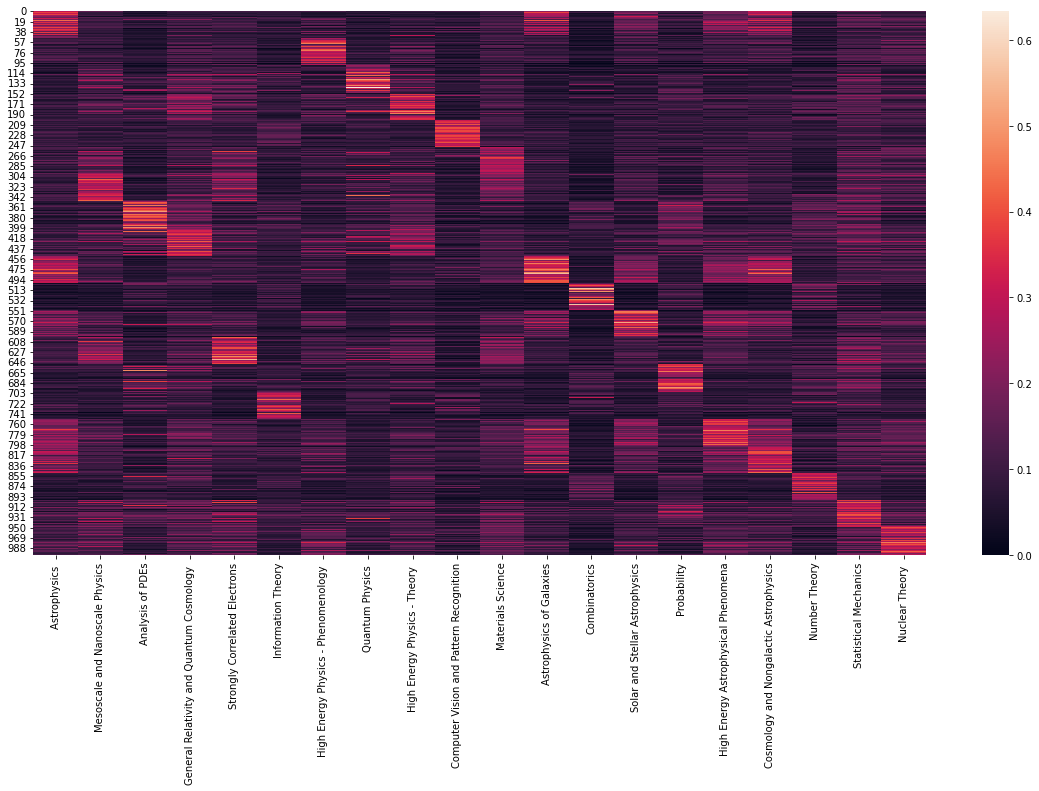

In [246]:
# Step 4 ======================================================================
# Plot a heat map or other appropriate
# visualizations to show the correlation between categories. Save the plot as an image file.
# You may use the matplotlib, seaborn, or any other Python data visualization libraries.
# =============================================================================
# plot the heat map of category-abstract matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cosine_similarity.transpose(),xticklabels=category_columns)

<AxesSubplot:>

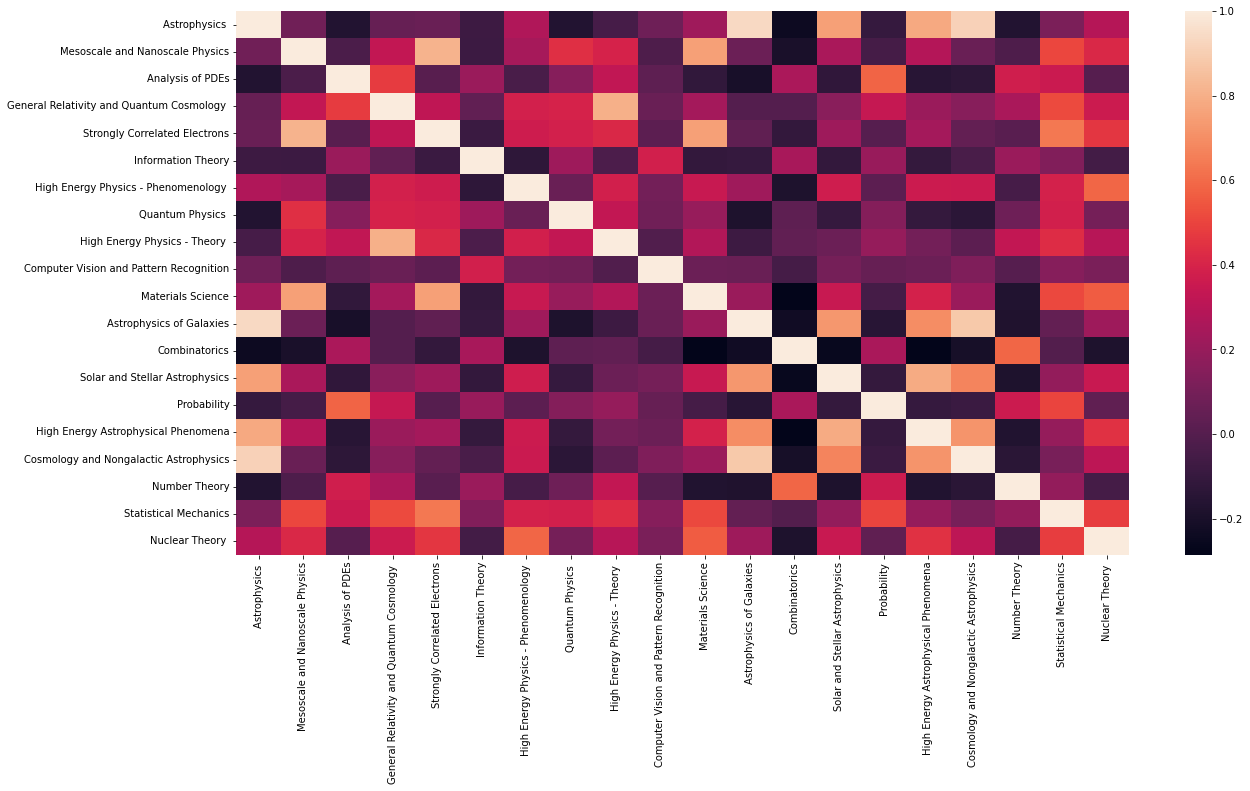

In [257]:
# to show the correlation among categories, use plot correlation matrix heat map
cor_cosine_similarity = np.corrcoef(cosine_similarity)
plt.figure(figsize=(20, 10))
sns.heatmap(cor_cosine_similarity,xticklabels=category_columns,yticklabels=category_columns)